[1.0, 1.0, 1.0, 1.0, 1.0, 0.96875, 0.967741935483871, 0.9666666666666667, 0.9655172413793104, 0.9642857142857143, 0.9629629629629629, 0.9615384615384616, 0.96, 0.9583333333333334, 0.9565217391304348, 0.9545454545454546, 0.9523809523809523, 0.95, 0.9473684210526315, 0.9444444444444444, 0.9411764705882353, 0.9375, 0.9333333333333333, 0.9285714285714286, 0.9230769230769231, 0.9166666666666666, 0.9090909090909091, 0.9, 0.8888888888888888, 0.875, 0.9142857142857144, 1.0]
[1.0, 1.0, 1.0, 1.0, 1.0, 0.9990234375, 0.9970674486803519, 0.9950980392156863, 0.993103448275862, 0.9910714285714286, 0.988988988988989, 0.9868421052631579, 0.9846153846153847, 0.9822916666666667, 0.9798515376458112, 0.9772727272727273, 0.9745293466223699, 0.9715909090909091, 0.968421052631579, 0.964975845410628, 0.9612015018773467, 0.95703125, 0.9523809523809523, 0.9471428571428572, 0.9411764705882353, 0.9342948717948718, 0.9262435677530018, 0.9166666666666666, 0.9050505050505051, 0.890625, 0.8721804511278195, 0.847701149

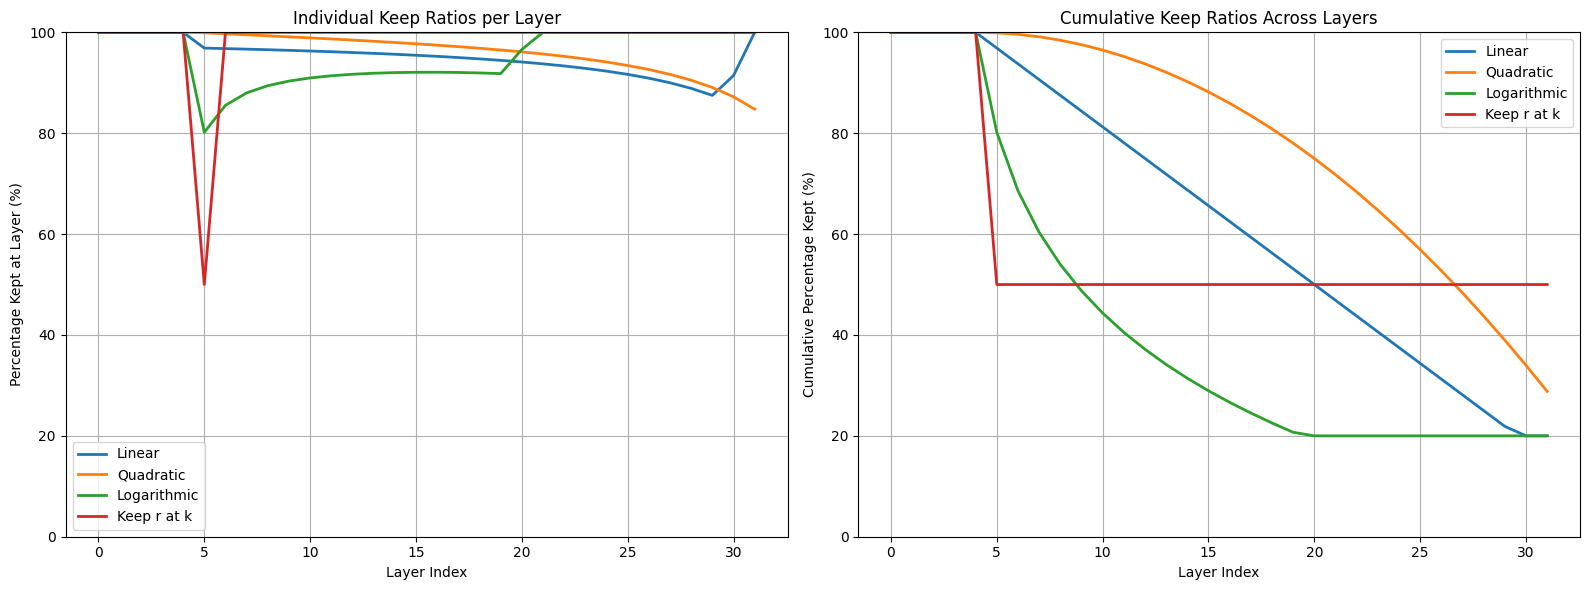

In [9]:
import numpy as np
import matplotlib.pyplot as plt

def _calc_cumulative_keep_ratio(f, layer_idx: int, K: int=0, min_keep_ratio: float = 0):
    """Calculate cumulative keep ratio at a given layer."""
    layer_idx = layer_idx - (K-1)
    if layer_idx < 0:
        return 1.0
    layer_prune_ratio = f(layer_idx)
    cumulative_layer_keep_ratio = 1 - layer_prune_ratio
    return max(cumulative_layer_keep_ratio, min_keep_ratio)

def _calc_individual_keep_ratios(f, total_layers, K=0, min_keep_ratio=0):
    """Calculate individual keep ratios from cumulative ratios."""
    individual_keep = []
    prev_cumulative = 1.0
    
    for layer in range(total_layers):
        current_cumulative = _calc_cumulative_keep_ratio(f, layer, K, min_keep_ratio)
        r_k = current_cumulative / prev_cumulative if prev_cumulative > 0 else 0.0
        r_k = max(r_k, min_keep_ratio)
        individual_keep.append(r_k)
        prev_cumulative = current_cumulative
    
    return individual_keep

# Fixed pruning strategy functions
def linear(x, T): return x / T
def quadratic(x, T): return (x ** 2) / (T ** 2)
def logarithmic(x, T): return np.log(x + 1) / np.log(T + 1)
def keep_r_at_k(x, r): return (1 - r) if x > 0 else 0  # Returns prune ratio

# Parameters
total_layers = 32
layers = np.arange(total_layers)
min_keep_ratio = 0.2
K=5

strategies = {
    "Linear": lambda x: linear(x, total_layers),
    "Quadratic": lambda x: quadratic(x, total_layers),
    "Logarithmic": lambda x: logarithmic(x, total_layers),
    "Keep r at k": lambda x: keep_r_at_k(x, 0.5),
}

# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot individual keep ratios
for name, strategy in strategies.items():
    individual_ratios = _calc_individual_keep_ratios(strategy, total_layers, K=K, min_keep_ratio=min_keep_ratio)
    ax1.plot(layers, [r * 100 for r in individual_ratios], label=name, linewidth=2)

ax1.set_xlabel('Layer Index')
ax1.set_ylabel('Percentage Kept at Layer (%)')
ax1.set_title('Individual Keep Ratios per Layer')
ax1.legend()
ax1.grid(True)
ax1.set_ylim(0, 100)

# Plot cumulative keep ratios - FIXED VERSION
for name, strategy in strategies.items():
    cumulative_keep = 1.0
    cumulative_ratios = []
    individual_ratios = _calc_individual_keep_ratios(strategy, total_layers, K=K, min_keep_ratio=min_keep_ratio)
    print(individual_ratios)
    for r in individual_ratios:
        cumulative_keep *= r
        cumulative_ratios.append(cumulative_keep * 100)
    
    ax2.plot(layers, cumulative_ratios, label=name, linewidth=2)

ax2.set_xlabel('Layer Index')
ax2.set_ylabel('Cumulative Percentage Kept (%)')
ax2.set_title('Cumulative Keep Ratios Across Layers')
ax2.legend()
ax2.grid(True)
ax2.set_ylim(0, 100)

plt.tight_layout()
plt.show()

In [8]:
import numpy as np

def calc_flops_for_layer(n: int, d: int = 1152, m: int = 18944):
    """Calculate FLOPs for a single transformer layer with n tokens"""
    return (4 * n * d**2) + (2 * n**2 * d) + (2 * n * d * m)

def calculate_total_flops(strategies, total_layers=32, initial_n=100, d=1152, m=18944, K=2, min_keep_ratio=0.0):
    """
    Calculate total FLOPs for different pruning strategies
    
    Args:
        strategies: Dictionary of pruning strategies {name: function}
        total_layers: Total number of layers
        initial_n: Initial number of tokens
        d: Hidden state size
        m: FFN intermediate size
        K: Layer delay before pruning starts
        min_keep_ratio: Minimum keep ratio
        
    Returns:
        Dictionary of total FLOPs for each strategy
    """
    flops_results = {}
    layers = np.arange(total_layers)
    
    for name, strategy in strategies.items():
        total_flops = 0
        n = initial_n  # Start with initial number of tokens
        
        for layer in layers:
            # Get cumulative keep ratio at current layer
            cumulative_keep = _calc_cumulative_keep_ratio(strategy, layer, K, min_keep_ratio)
            
            # Update number of tokens (n_hat = n * cumulative_keep)
            current_n = n * cumulative_keep
            
            # Calculate FLOPs for this layer and add to total
            total_flops += calc_flops_for_layer(current_n, d, m)
            
            # Update n for next layer (if doing cumulative pruning)
            # Note: For independent pruning, you wouldn't update n here
            n = current_n
        
        flops_results[name] = total_flops
    
    return flops_results

# Define pruning strategies (same as before)
strategies = {
    "Linear": lambda x: linear(x, total_layers),
    "Quadratic": lambda x: quadratic(x, total_layers),
    "Logarithmic": lambda x: logarithmic(x, total_layers),
    "Keep 50% at layer 2": lambda x: keep_r_at_k(x, 0.5, 2, total_layers),
}

# Calculate FLOPs for each strategy
flops_results = calculate_total_flops(
    strategies,
    total_layers=32,
    initial_n=100,  # Starting with 100 tokens
    K=2,           # Start pruning at layer 2
    min_keep_ratio=0.0
)

# Print results in scientific notation
for name, flops in flops_results.items():
    print(f"{name}: {flops:.2e}")

Linear: 4.31e+10
Quadratic: 7.22e+10
Logarithmic: 2.46e+10
Keep 50% at layer 2: 2.46e+10


0.6920398436307741